In [2]:
import pandas as pd # data processing, CSV I/O
from sklearn.preprocessing import LabelEncoder

# import librerie per le reti neurali
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Conv1D, GlobalMaxPooling1D
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence

from matplotlib import pyplot as plt

from numpy.random import seed
seed(42)

import tensorflow
tensorflow.random.set_seed(42)


In [31]:
DATA_FILE = 'spam.csv'
df = pd.read_csv(DATA_FILE,encoding='latin-1')
print(df.head())
print('---------')

tags = df.v1
texts = df.v2

print(tags[:3])
print(texts[:3])


     v1                                                 v2 Unnamed: 2  \
0   ham  Go until jurong point, crazy.. Available only ...        NaN   
1   ham                      Ok lar... Joking wif u oni...        NaN   
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...        NaN   
3   ham  U dun say so early hor... U c already then say...        NaN   
4   ham  Nah I don't think he goes to usf, he lives aro...        NaN   

  Unnamed: 3 Unnamed: 4  
0        NaN        NaN  
1        NaN        NaN  
2        NaN        NaN  
3        NaN        NaN  
4        NaN        NaN  
---------
0     ham
1     ham
2    spam
Name: v1, dtype: object
0    Go until jurong point, crazy.. Available only ...
1                        Ok lar... Joking wif u oni...
2    Free entry in 2 a wkly comp to win FA Cup fina...
Name: v2, dtype: object


In [29]:
'''
Tokenizer consente di vettorializzare un corpus di testo, trasformando i testi
in una sequenza di numeri interi (ogni numero intero è l'indice di un token in
un dizionario) o in un vettore in cui il coefficiente potrebbe essere binario,
basato sul conteggio delle parole, ecc...
# Argomenti
num_words:  il numero massimo di parole da conservare, in base
            alla frequenza delle parole stesse.
filters:    una stringa in cui ogni elemento è un carattere che sarà
            filtrato dai testi. L'impostazione predefinita è tutta la punteggiatura,
            oltre a interruzioni di riga e caratteri speciali.
lower:      booleano. Se convertire i testi in minuscolo.
split:      carattere o stringa da utilizzare per la divisione del token.
char_level: se True, ogni carattere sarà trattato come un token.
oov_token:  se presente, verrà aggiunto a word_index e utilizzato per
            sostituire le parole fuori dal vocabolario durante le chiamate
            text_to_sequence

Per impostazione predefinita, tutta la punteggiatura viene rimossa, trasformando i testi in
sequenze di parole separate dallo spazio.
Queste sequenze sono quindi divise in elenchi di token che verranno indicizzati o vettorializzati.

"0" è un indice riservato che non verrà assegnato a nessuna parola.
'''

# Esempio di utilizzo di tokenizer su un set ristretto di documenti (scopi didattici)
example_num_max = 5 # -> dimensione del vocabolario di parole che vogliamo "tracciare"
example_tok = Tokenizer(num_words=example_num_max)
example_texts = [
    "HELLO MY WORLD",
    "MY WORLD",
    "AHAHHA WORLD",
    "AHAHHA AHAHHA"
] # Set di documenti su cui effettuare la tokenizzazione. Ogni elemento della lista rappresenta un documento

example_tok.fit_on_texts(example_texts)

print(example_texts, "\n")
print("word_index         -> ", example_tok.word_index, "\n") # dizionario in cui ogni parola è associata ad un id intero
print("document_count     -> ", example_tok.document_count, "\n") # numero di frasi (o documenti, nel nostro caso quante mail abbiamo nel dataset) usate per generare il dizionario
print("word_docs          -> ", example_tok.word_docs, "\n") # dizionario con il numero di documenti in cui appare la singola parola
print("word_counts        -> ", example_tok.word_counts, "\n") # dizionario con parole e numero di occorrenze delle parole

example_mat_texts = example_tok.texts_to_matrix(example_texts,mode='count') # matrice di occorrenze delle parole nei document
# altre modalità di tokenizzazione in matrice sono "binary", "freq", "tfidf"

print(example_mat_texts)
print("\n\n\n")

example_sequences = example_tok.texts_to_sequences(example_texts) # per il preprocessing nella CNN -> texts_to_sequences

print("texts_to_sequences  -> ", example_sequences)
print("after pad_sequences ->", sequence.pad_sequences(example_sequences,maxlen=example_num_max))

# example_sequences è una lista che contiene tante liste quante sono i testi
# ogni elemento di questa lista contiene non più le parole sottoforma di stringa, ma gli id presenti nel dizionario
# grazie a pad_sequences rendiamo tutti i testi della stessa lunghezza


['HELLO MY WORLD', 'MY WORLD', 'AHAHHA WORLD', 'AHAHHA AHAHHA'] 

word_index         ->  {'world': 1, 'ahahha': 2, 'my': 3, 'hello': 4} 

document_count     ->  4 

word_docs          ->  defaultdict(<class 'int'>, {'hello': 1, 'my': 2, 'world': 3, 'ahahha': 2}) 

word_counts        ->  OrderedDict([('hello', 1), ('my', 2), ('world', 3), ('ahahha', 3)]) 

[[0. 1. 0. 1. 1.]
 [0. 1. 0. 1. 0.]
 [0. 1. 1. 0. 0.]
 [0. 0. 2. 0. 0.]]




texts_to_sequences  ->  [[4, 3, 1], [3, 1], [2, 1], [2, 2]]
after pad_sequences -> [[0 0 4 3 1]
 [0 0 0 3 1]
 [0 0 0 2 1]
 [0 0 0 2 2]]


In [6]:
# preprocessing del dataset. Facciamo le stesse operazioni di prima ma sul vero dataset
num_max = 1000 # numero di parole diverse considerate dal modello
le = LabelEncoder() # codifica tag (classi) diverse in "indici numerici"
tags = le.fit_transform(tags)

tok = Tokenizer(num_words=num_max)

# Creazione di un vocabolario di indici per rappresentare
# le parole dei testi passati in input
# Il vocabolario è ordinato dalla parola più frequente
# a quella meno frequente

tok.fit_on_texts(texts)

 
# Creazione di una matrice dai testi originali
# Ogni riga è un vettore di dimensione = al vocabolario
# I testi iniziali vengono convertiti utilizzando il
# vocabolario creato al passo precedente
# Le parole sostituite con il valore 0 sono quelle meno frequenti
# mat_texts = tok.texts_to_matrix(texts,mode='count')
mat_texts = tok.texts_to_matrix(texts,mode='count')

print(tags[:5])
print('---------')
print(mat_texts[:5])
print('---------')
print(tags.shape, mat_texts.shape)

[0 0 1 0 0]
---------
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 3. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 1. 1. ... 0. 0. 0.]]
---------
(5572,) (5572, 1000)


In [10]:
# rete neurale "dense" come primo modello
def get_simple_model():
    model = Sequential()
    model.add(Dense(256, activation='relu', input_shape=(num_max,)))
    model.add(Dense(256, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.summary()
    model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['acc'])
    print('- modello compilato -')
    return model

def check_model(model,x,y):
    return model.fit(x,y,batch_size=32,epochs=10,verbose=2,validation_split=0.2)

m = get_simple_model()
dense = check_model(m,mat_texts,tags)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 256)               256256    
_________________________________________________________________
dense_5 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 257       
Total params: 322,305
Trainable params: 322,305
Non-trainable params: 0
_________________________________________________________________
- modello compilato -
Epoch 1/10
140/140 - 2s - loss: 0.1582 - acc: 0.9497 - val_loss: 0.0634 - val_acc: 0.9865
Epoch 2/10
140/140 - 0s - loss: 0.0288 - acc: 0.9919 - val_loss: 0.0745 - val_acc: 0.9848
Epoch 3/10
140/140 - 0s - loss: 0.0083 - acc: 0.9973 - val_loss: 0.0753 - val_acc: 0.9874
Epoch 4/10
140/140 - 0s - loss: 0.0042 - acc: 0.9987 - val_loss: 0.0868 - val_acc: 0.9

In [11]:
# preprocessing per una CNN

max_len = 100
# Conversione dei testi di input in sequenze di indici
# del vocabolario utilizzato
cnn_texts_seq = tok.texts_to_sequences(texts)
print(cnn_texts_seq[0])
print('---------')

# Aggiunta di padding (zeri) per rendere
# ogni frase della stessa lunghezza di parole
cnn_texts_mat = sequence.pad_sequences(cnn_texts_seq,maxlen=max_len)
print(cnn_texts_mat[0])
print('---------')
print(cnn_texts_mat.shape)

[50, 469, 841, 751, 657, 64, 8, 89, 121, 349, 147, 67, 58, 144]
---------
[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0  50 469 841 751
 657  64   8  89 121 349 147  67  58 144]
---------
(5572, 100)


In [12]:
# CNN per la classificazione del testo
def get_cnn_model():   
    model = Sequential()
    model.add(Embedding # simile alla PCA
                        (1000, # dimensione del vocabolario
                        100,    # dimensione dei vettori di embedding in uscita
                        input_length=max_len))
    model.add(Conv1D(128,
                     3,
                     padding='valid',
                     activation='relu',
                     strides=1))
    model.add(GlobalMaxPooling1D())
    model.add(Dense(256))
    model.add(Activation('relu'))
    model.add(Dense(1))
    model.add(Activation('sigmoid'))
    model.summary()
    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['acc'])
    return model

m = get_cnn_model()
cnn = check_model(m,cnn_texts_mat,tags)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 100, 100)          100000    
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 98, 128)           38528     
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 128)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 256)               33024     
_________________________________________________________________
activation_4 (Activation)    (None, 256)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 257       
_________________________________________________________________
activation_5 (Activation)    (None, 1)                

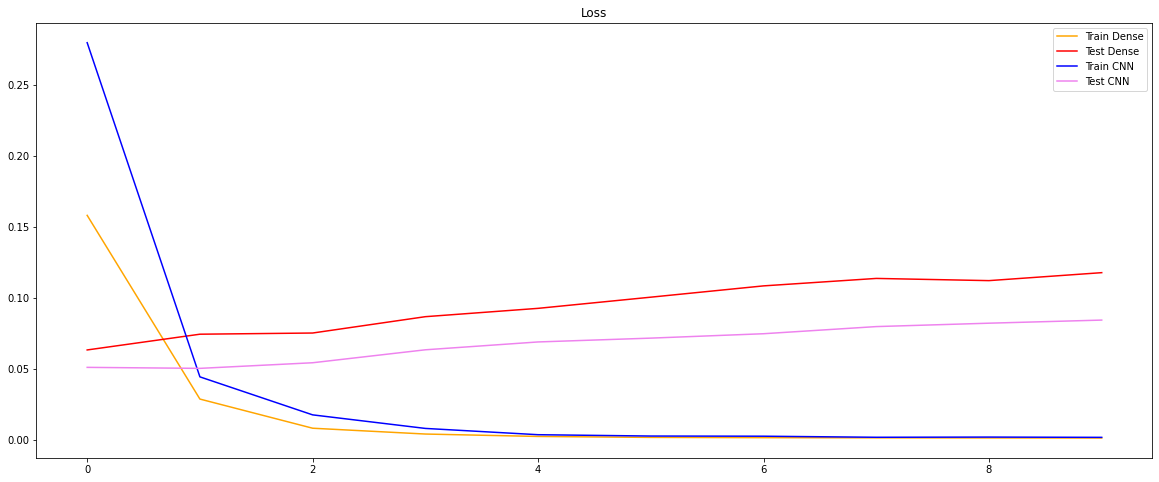

In [13]:
plt.figure(figsize=(20, 8))
plt.plot(dense.history['loss'], color='orange', label='Train Dense')
plt.plot(dense.history['val_loss'], color='red', label='Test Dense')
plt.plot(cnn.history['loss'], color='blue', label='Train CNN')
plt.plot(cnn.history['val_loss'], color='violet', label='Test CNN')
plt.title('Loss')
plt.legend()
plt.show()

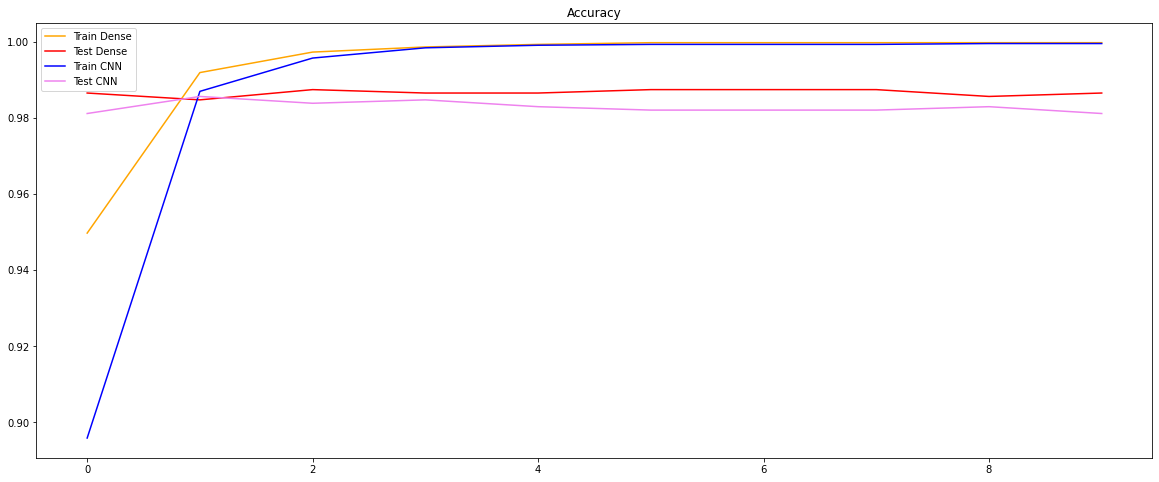

In [14]:
plt.figure(figsize=(20, 8))
plt.plot(dense.history['acc'], color='orange', label='Train Dense')
plt.plot(dense.history['val_acc'], color='red', label='Test Dense')
plt.plot(cnn.history['acc'], color='blue', label='Train CNN')
plt.plot(cnn.history['val_acc'], color='violet', label='Test CNN')
plt.title('Accuracy')
plt.legend()
plt.show()